# Post processing and visualizing mandyoc data

The following notebook allows the user to visualize a given mandyoc output (e.g.: `'temperature'`, `'strain_rate'`, `'lithology'`, etc) according to a given number of time instants (e.g.: `instants = [0, 10, 20, 30]` Myr. `len(instants)` must be >= 2.

For a given instant in the `instants` the script will find the closest time step to this instant and plot the respective output.

In [1]:
#increase the display size to 95% of window width
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
display(HTML("<style>.output_result { max-width:95% !important; }</style>"))


import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import interp1d
import glob
import os
import sys
import pylab as pl
import xarray as xr
import pymp
import mpl_toolkits.axisartist
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
import string
import matplotlib.cm as cm
from cmcrameri import cm as cr

path = os.getcwd().split('/')
machine_path = '/'+path[1]+'/'+path[2] #cat the /home/user/ or /Users/user from system using path

sys.path.insert(0, f"{machine_path}/opt/scripts/functions")
from mandyocIO import read_datasets, change_dataset, plot_property, find_nearest, plot_tracked_particles_depth_coded, plot_ptt_paths_depth_coded

# How to plot

## In the following cell, you must inform:
 - The path to your `scenario` without `/OS_home/username` because this is collected by `machine_path`.
     - Ex.: `/mandyoc/experiments/my_experiment/`
 - The mandyoc property `prop` that you want to visualize uncommenting one the commented options.
     - `prop = 'lithology'` is the default.
 - The values in list `instants` containing the instants that you want to visualize.
     - Ex: `instants = [0, 10, 20, 30]` #Myr

In [2]:
# crust35 = True
crust35 = False

#Set scenario path
local = False
if(local==True):
    model_path = machine_path
else:
    external_media = 'Joao_Macedo'
    model_path = f"/Volumes/{external_media}"

if(crust35 == True):
    hcrust = 35.0e3 #m
    v = 1
    # v = 2
    print(f"Comparing Homogeneous vs Thinned lithosphere with 35 km thick crust and v = {v}")
    if(v==1):
        scenarios = [
                    f"{model_path}/Doutorado/cenarios/mandyoc/rifting/Melting/lit120km/DT230_Tp1350oC/v1/RFT_DT230_Tp1350oC_v1_Clc1_checkered_false",
                    f"{model_path}/Doutorado/cenarios/mandyoc/rifting/Melting/lit120km/DT230_Tp1350oC/v1/RFT_DT230_Tp1350oC_v1_Clc10_checkered_false",
                    f"{model_path}/Doutorado/cenarios/mandyoc/rifting/Melting/lithoramp/DT230_Tp1350oC/v1/RFT_lithoramp_DT230_Tp1350oC_v1_Clc1_checkered_false",
                    f"{model_path}/Doutorado/cenarios/mandyoc/rifting/Melting/lithoramp/DT230_Tp1350oC/v1/RFT_lithoramp_DT230_Tp1350oC_v1_Clc10_checkered_false",
                    ]
    elif(v==2):
        scenarios = [
                    f"{model_path}/Doutorado/cenarios/mandyoc/rifting/Melting/lit120km/DT230_Tp1350oC/v2/RFT_DT230_Tp1350oC_v2_Clc1_checkered_false",
                    f"{model_path}/Doutorado/cenarios/mandyoc/rifting/Melting/lit120km/DT230_Tp1350oC/v2/RFT_DT230_Tp1350oC_v2_Clc10_checkered_false",
                    f"{model_path}/Doutorado/cenarios/mandyoc/rifting/Melting/lithoramp/DT230_Tp1350oC/v2/RFT_lithoramp_DT230_Tp1350oC_v2_Clc1_checkered_false",
                    f"{model_path}/Doutorado/cenarios/mandyoc/rifting/Melting/lithoramp/DT230_Tp1350oC/v2/RFT_lithoramp_DT230_Tp1350oC_v2_Clc10_checkered_false",
                    ]
else:
    hcrust = 40.0e3 #m
    print(f"Comparing 40 km thick crust v = 1 and 2 cm/yr")
    scenarios = [
                f"{model_path}/Doutorado/cenarios/mandyoc/rifting/Melting/lit120km/DT230_Tp1350oC/crust40km/v1/RFT_DT230_Tp1350oC_crust40km_v1_Clc1_checkered_false",
                f"{model_path}/Doutorado/cenarios/mandyoc/rifting/Melting/lit120km/DT230_Tp1350oC/crust40km/v1/RFT_DT230_Tp1350oC_crust40km_v1_Clc10_checkered_false",
                f"{model_path}/Doutorado/cenarios/mandyoc/rifting/Melting/lit120km/DT230_Tp1350oC/crust40km/v2/RFT_DT230_Tp1350oC_crust40km_v2_Clc1_checkered_false",
                f"{model_path}/Doutorado/cenarios/mandyoc/rifting/Melting/lit120km/DT230_Tp1350oC/crust40km/v2/RFT_DT230_Tp1350oC_crust40km_v2_Clc10_checkered_false",
                ]

read_ascii = True # if False, it will skip the ascii reading and saving processes and it will read the datasets from previous runs
save_images = True # Generate and save all the possible images
save_big_dataset = False#True
plot_isotherms = True
# plot_melt = True
plot_melt = False

if(plot_isotherms or plot_melt):
    clean_plot=False
else:
    clean_plot = True

datasets = [#Properties from mandyoc. Comment/uncomment to select properties of the dataset
            'density',
            'radiogenic_heat',
            'pressure',
            'strain',
            'strain_rate',### Read ascii outputs and save them as xarray.Datasets,
            'surface',
            'temperature',
            'viscosity'
            ]# Read data and convert them to xarray.Dataset

properties = [#Properties from mandyoc. Comment/uncomment to select which ones you would like to plot
            #  'density',
#              'radiogenic_heat',
             'lithology',
#              'pressure',
            #  'strain',
            #  'strain_rate',
            #  'temperature',
            #  'temperature_anomaly',
            #  'surface',
            #  'viscosity'
             ]

# Read ascii outputs and save them as xarray.Datasets

new_datasets = change_dataset(properties, datasets)

to_remove = []
remove_density=False
if ('density' not in properties): #used to plot air/curst interface
        properties.append('density')
        new_datasets = change_dataset(properties, datasets)
        to_remove.append('density')
        # remove_density=True

if ('surface' not in properties): #used to plot air/curst interface
        properties.append('surface')
        new_datasets = change_dataset(properties, datasets)
        to_remove.append('surface')
        # remove_density=True

if (plot_isotherms): #add datasets needed to plot isotherms
    if ('temperature' not in new_datasets):
        properties.append('temperature')
        new_datasets = change_dataset(properties, datasets)
        to_remove.append('temperature')

# print(f"newdataset4 {new_datasets}")

if (plot_melt): #add datasets needed to plot melt fraction
    if ('pressure' not in new_datasets):
        properties.append('pressure')
    if ('temperature' not in new_datasets):
        properties.append('temperature')
    new_datasets = change_dataset(properties, datasets)

    #removing the auxiliary datasets to not plot
    to_remove.append('pressure')
    to_remove.append('temperature')

if(clean_plot): #a clean plot
    new_datasets = change_dataset(properties, datasets)

for item in to_remove:
    properties.remove(item)

dataset0 = read_datasets(scenarios[0], new_datasets)
dataset1 = read_datasets(scenarios[1], new_datasets)
dataset2 = read_datasets(scenarios[2], new_datasets)
dataset3 = read_datasets(scenarios[3], new_datasets)

# Normalize velocity values
if ("velocity_x" and "velocity_z") in dataset0.data_vars:
    v_max = np.max((dataset0.velocity_x**2 + dataset0.velocity_z**2)**(0.5))    
    dataset0.velocity_x[:] = dataset0.velocity_x[:] / v_max
    dataset0.velocity_z[:] = dataset0.velocity_z[:] / v_max

if ("velocity_x" and "velocity_z") in dataset1.data_vars:
    v_max = np.max((dataset1.velocity_x**2 + dataset1.velocity_z**2)**(0.5))    
    dataset1.velocity_x[:] = dataset1.velocity_x[:] / v_max
    dataset1.velocity_z[:] = dataset1.velocity_z[:] / v_max

if ("velocity_x" and "velocity_z") in dataset2.data_vars:
    v_max = np.max((dataset2.velocity_x**2 + dataset2.velocity_z**2)**(0.5))    
    dataset2.velocity_x[:] = dataset2.velocity_x[:] / v_max
    dataset2.velocity_z[:] = dataset2.velocity_z[:] / v_max


Nx = int(dataset0.nx)
Nz = int(dataset0.nz)
Lx = float(dataset0.lx)
Lz = float(dataset0.lz)

x = np.linspace(0, Lx/1000.0, Nx)
z = np.linspace(Lz/1000.0, 0, Nz)
xx, zz  = np.meshgrid(x, z)

# print(f"\n{dataset0.info}")

trackdataset0 = xr.open_dataset(f"{scenarios[0]}/_track_xzPT_all_steps.nc")
trackdataset1 = xr.open_dataset(f"{scenarios[1]}/_track_xzPT_all_steps.nc")
trackdataset2 = xr.open_dataset(f"{scenarios[2]}/_track_xzPT_all_steps.nc")
trackdataset3 = xr.open_dataset(f"{scenarios[3]}/_track_xzPT_all_steps.nc")

#PTt data from McCarthy et al. (2020) and Muntener et al. (2009)
McCarthy_data = pd.read_excel(f"PTt_Data/McCarthy_Fig9_datasets.xlsx")
Muntener_data = pd.read_excel(f"PTt_Data/Muntener_Fig16_datasets.xlsx")
Johanesen_data = pd.read_excel(f"PTt_Data/Johanesen_Fig7_datasets.xlsx")

Comparing 40 km thick crust v = 1 and 2 cm/yr


Margin_Evolution_Hc40km_v1vsv2_with_PTt_depth_coded_lithology


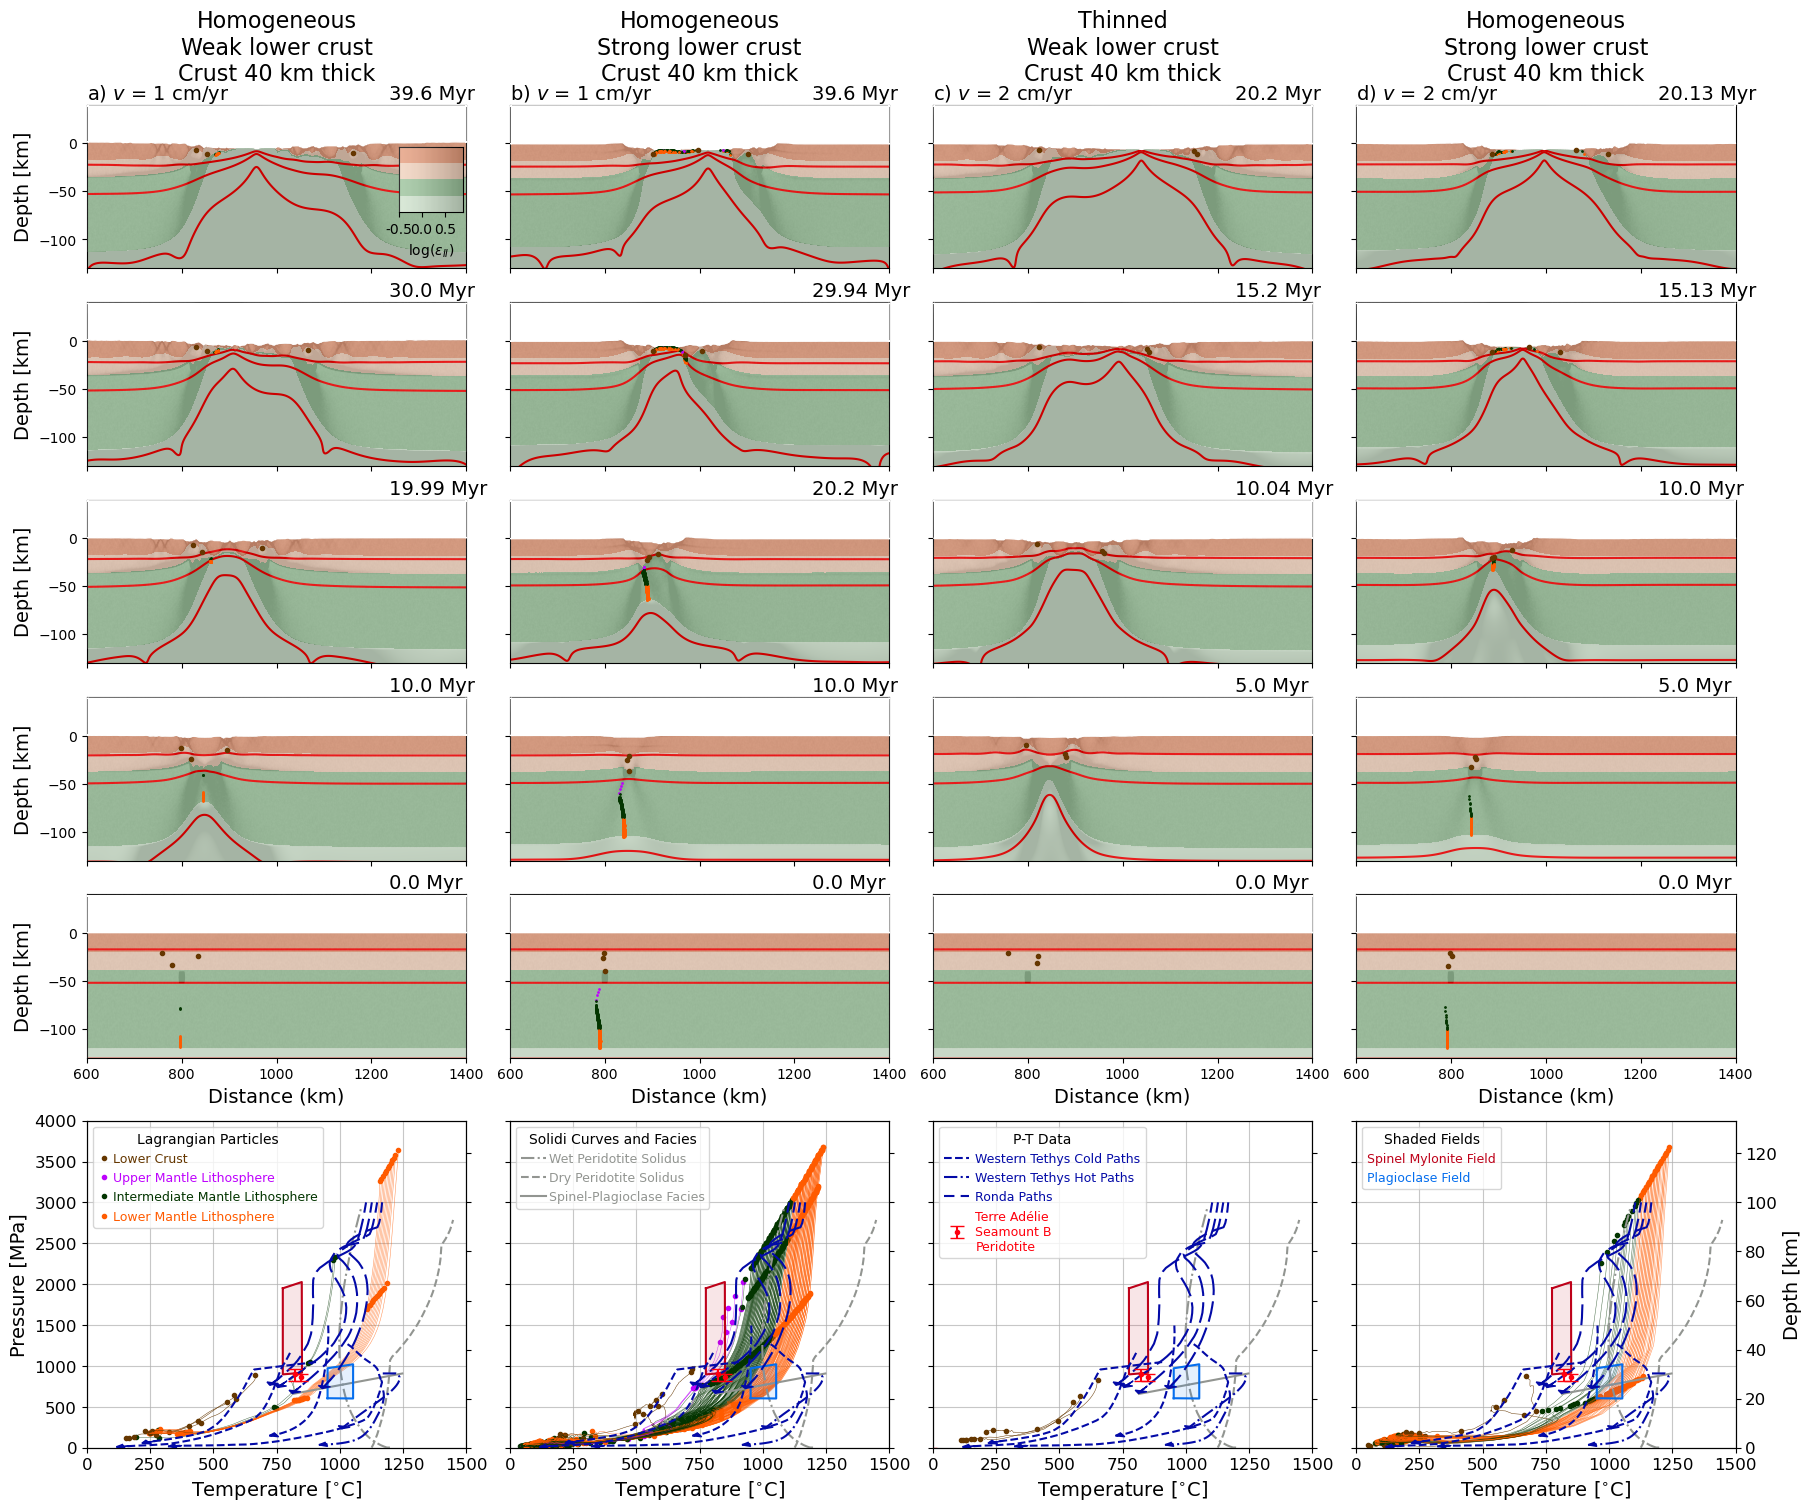

In [ ]:
##############################################################################################################
#Set mandyoc property

# prop = 'density'
# prop = 'heat'
prop = 'lithology'
# prop = 'pressure'
# prop = 'strain'
# prop = 'strain_rate'
# prop = 'temperature'
# prop = 'temperature_anomaly'
# prop = 'viscosity'
# prop = 'surface'

if(crust35 == True):
    if(v==1):
        # instants = [0, 10, 20, 30, 40] #Myr
        instants = [40, 30, 20, 10, 0] #Myr
    if(v==2):
        # instants = [0, 5., 10., 15., 20.] #Myr
        instants = [40, 30, 20, 10, 0] #Myr
else:
    # instants = [0, 10, 20, 30, 40] #divide by 2 whent v=2 cm/yr
    instants = [40, 30, 20, 10, 0] #Myr

plt.close('all')

fig_height = (3.0/2.0)*(len(instants) + 5) #6 minimum
fig = plt.figure(figsize=(18, fig_height), constrained_layout=True)

mosaic = """
         ABCD
         EFGH
         IJKL
         MNOP
         QRST
         UVWX
         """
axs = fig.subplot_mosaic(mosaic, gridspec_kw={'height_ratios':[0.5,
                                                               0.5,
                                                               0.5,
                                                               0.5,
                                                               0.5,
                                                               1.0
                                                              ]
                                             }
                        )

alphabet = list(string.ascii_uppercase)
idxs = np.asarray(alphabet[0: len(instants)*len(scenarios)]) #starting at A subplot
idxs_aux = idxs.reshape(len(instants), len(scenarios))

i = 0
# zoom_uc = True
zoom_uc = False

Lcraton = 1200.0

if(prop != 'surface'): # you can customize
    if(zoom_uc):
        xlims = [float(dataset0.isel(time=i).lx)/2.0e3 - Lcraton/2 - 50, float(dataset0.isel(time=i).lx)/2.0e3 + Lcraton/2 + 50]
        ylims = [-40, 10]
        # plot steps
        plot_particles = True
    else:
        # xlims = [0, float(dataset0.isel(time=i).lx) / 1.0e3]
        # ylims = [-float(dataset0.isel(time=i).lz) / 1.0e3 + 40, 40]
        xlims = [600, 1400]
        ylims = [-130, 40]
        # plot steps
        plot_particles = False
        # print(xlims, ylims)
else: #for surface plot
    if(zoom_uc):
        xlims = [float(dataset0.isel(time=i).lx)/2.0e3 - Lcraton/2 - 150, float(dataset0.isel(time=i).lx)/2.0e3 + Lcraton/2 + 150]
        ylims = [-1.0, 1.0]
        
    else:
        xmin = 0 #+ 200
        xmax = float(dataset0.isel(time=i).lx) / 1.0E3 #- 200
        xlims = [xmin, xmax]
        ylims = [-1.5, 1.5]

topo_from_density = True
# topo_from_density = False
# plot_other_particles = True
plot_other_particles = False

color_lower_crust = 'xkcd:brown'
color_mlit_upper='xkcd:bright purple'#'xkcd:cerulean blue'
color_mlit_intermediate='xkcd:dark green'#'xkcd:scarlet'
color_mlit_lower='xkcd:bright orange'#'xkcd:dark green'

for instant, i in zip(instants, range(len(instants))):
    idx0 = find_nearest(dataset0.time, instant)
    idx1 = find_nearest(dataset1.time, instant)
    idx2 = find_nearest(dataset2.time, instant) if crust35 == True else find_nearest(dataset2.time, int(instant/2))
    idx3 = find_nearest(dataset3.time, instant) if crust35 == True else find_nearest(dataset3.time, int(instant/2))

    if(instant == instants[0]):
        plot_colorbar = True
    else:
        plot_colorbar = False

    plot_property(dataset0.isel(time=idx0), prop, xlims, ylims, scenarios[0],
             fig,
             axs[idxs_aux[i, 0]],
             plot_isotherms = plot_isotherms,
             topo_from_density = topo_from_density,
             plot_particles = plot_particles,
             particle_size = 0.2,
             particle_marker = ".",
             ncores = 20,
            #  step_plot = 4,
             isotherms = [500, 800, 1300],
             plot_colorbar=plot_colorbar,
             bbox_to_anchor=(0.84,#horizontal position respective to parent_bbox or "loc" position
                            0.3,# vertical position
                            0.17,# width
                            0.40),
             # plot_melt = plot_melt,
             # melt_method = melt_method,
            )
    # plot_tracked_particles(trackdataset0, axs[idxs_aux[i, 0]], idx0, plot_other_particles=plot_other_particles, color_other_particles='xkcd:black', size_other_particles=4)
    plot_tracked_particles_depth_coded(trackdataset0, axs[idxs_aux[i, 0]], idx0, hcrust=hcrust, plot_other_particles=plot_other_particles, size_other_particles=4, color_lower_crust=color_lower_crust, color_mlit_upper=color_mlit_upper, color_mlit_intermediate=color_mlit_intermediate, color_mlit_lower=color_mlit_lower)

    plot_property(dataset1.isel(time=idx1), prop, xlims, ylims, scenarios[1],
             fig,
             axs[idxs_aux[i, 1]],
             plot_isotherms = plot_isotherms,
             topo_from_density = topo_from_density,
             plot_particles = plot_particles,
             particle_size = 0.2,
             particle_marker = ".",
             ncores = 20,
            #  step_plot = 4,
             isotherms = [500, 800, 1300],
             plot_colorbar=False,
             
             # plot_melt = plot_melt,
             # melt_method = melt_method,
            )
    # plot_tracked_particles(trackdataset1, axs[idxs_aux[i, 1]], idx1, plot_other_particles=plot_other_particles, color_other_particles='xkcd:black', size_other_particles=4)
    plot_tracked_particles_depth_coded(trackdataset1, axs[idxs_aux[i, 1]], idx1, hcrust=hcrust, plot_other_particles=plot_other_particles, size_other_particles=4,
                                       color_lower_crust=color_lower_crust, color_mlit_upper=color_mlit_upper, color_mlit_intermediate=color_mlit_intermediate, color_mlit_lower=color_mlit_lower)

    plot_property(dataset2.isel(time=idx2), prop, xlims, ylims, scenarios[2],
             fig,
             axs[idxs_aux[i, 2]],
             plot_isotherms = plot_isotherms,
             topo_from_density = topo_from_density,
             plot_particles = plot_particles,
             particle_size = 0.2,
             particle_marker = ".",
             ncores = 20,
            #  step_plot = 4,
             isotherms = [500, 800, 1300],
             plot_colorbar=False,
             
             # plot_melt = plot_melt,
             # melt_method = melt_method,
            )
    # plot_tracked_particles(trackdataset2, axs[idxs_aux[i, 2]], idx2, plot_other_particles=plot_other_particles)
    plot_tracked_particles_depth_coded(trackdataset2, axs[idxs_aux[i, 2]], idx2, hcrust=hcrust, plot_other_particles=plot_other_particles, size_other_particles=4,
                                       color_lower_crust=color_lower_crust, color_mlit_upper=color_mlit_upper, color_mlit_intermediate=color_mlit_intermediate, color_mlit_lower=color_mlit_lower)

    plot_property(dataset3.isel(time=idx3), prop, xlims, ylims, scenarios[3],
             fig,
             axs[idxs_aux[i, 3]],
             plot_isotherms = plot_isotherms,
             topo_from_density = topo_from_density,
             plot_particles = plot_particles,
             particle_size = 0.2,
             particle_marker = ".",
             ncores = 20,
            #  step_plot = 4,
             isotherms = [500, 800, 1300],
             plot_colorbar=False,
             
             # plot_melt = plot_melt,
             # melt_method = melt_method,
            )
    # plot_tracked_particles(trackdataset3, axs[idxs_aux[i, 3]], idx3, plot_other_particles=plot_other_particles, color_other_particles='xkcd:black', size_other_particles=4)
    plot_tracked_particles_depth_coded(trackdataset3, axs[idxs_aux[i, 3]], idx3, hcrust=hcrust, plot_other_particles=plot_other_particles,
                                       size_other_particles=4, color_lower_crust=color_lower_crust, color_mlit_upper=color_mlit_upper, color_mlit_intermediate=color_mlit_intermediate, color_mlit_lower=color_mlit_lower)


# plot_ptt_paths(trackdataset0, axs['Q'], instants)
# plot_ptt_paths(trackdataset1, axs['R'], instants)
# plot_ptt_paths(trackdataset2, axs['S'], instants)
# plot_ptt_paths(trackdataset3, axs['T'], instants)

color_other_particles='xkcd:black'
size_other_particles=2

idxs_ptts = np.asarray(alphabet[len(instants)*len(scenarios): len(instants)*len(scenarios)+len(scenarios)])
# plot_ptt_paths(trackdataset0, axs[idxs_ptts[0]], instants, plot_other_particles=plot_other_particles, color_other_particles=color_other_particles, size_other_particles=size_other_particles)
# plot_ptt_paths(trackdataset1, axs[idxs_ptts[1]], instants, plot_other_particles=plot_other_particles, color_other_particles=color_other_particles, size_other_particles=size_other_particles)
# instants_aux = instants if crust35 == True else [int(instant/2) for instant in instants]
# plot_ptt_paths(trackdataset2, axs[idxs_ptts[2]], instants_aux, plot_other_particles=plot_other_particles, color_other_particles=color_other_particles, size_other_particles=size_other_particles)
# plot_ptt_paths(trackdataset3, axs[idxs_ptts[3]], instants_aux, plot_other_particles=plot_other_particles, color_other_particles=color_other_particles, size_other_particles=size_other_particles)


plot_ptt_paths_depth_coded(trackdataset0, axs[idxs_ptts[0]], instants, hcrust=hcrust, plot_other_particles=plot_other_particles, color_other_particles=color_other_particles, size_other_particles=size_other_particles, color_lower_crust=color_lower_crust, color_mlit_upper=color_mlit_upper, color_mlit_intermediate=color_mlit_intermediate, color_mlit_lower=color_mlit_lower)
plot_ptt_paths_depth_coded(trackdataset1, axs[idxs_ptts[1]], instants, hcrust=hcrust, plot_other_particles=plot_other_particles, color_other_particles=color_other_particles, size_other_particles=size_other_particles, color_lower_crust=color_lower_crust, color_mlit_upper=color_mlit_upper, color_mlit_intermediate=color_mlit_intermediate, color_mlit_lower=color_mlit_lower)
# instants_aux = instants if crust35 == True else [int(instant/2) for instant in instants]
plot_ptt_paths_depth_coded(trackdataset2, axs[idxs_ptts[2]], instants, hcrust=hcrust, plot_other_particles=plot_other_particles, color_other_particles=color_other_particles, size_other_particles=size_other_particles, color_lower_crust=color_lower_crust, color_mlit_upper=color_mlit_upper, color_mlit_intermediate=color_mlit_intermediate, color_mlit_lower=color_mlit_lower)
plot_ptt_paths_depth_coded(trackdataset3, axs[idxs_ptts[3]], instants, hcrust=hcrust, plot_other_particles=plot_other_particles, color_other_particles=color_other_particles, size_other_particles=size_other_particles, color_lower_crust=color_lower_crust, color_mlit_upper=color_mlit_upper, color_mlit_intermediate=color_mlit_intermediate, color_mlit_lower=color_mlit_lower)

fsize = 14

# axs[1].yaxis.set_label_position("right")
# axs[1].tick_params(axis='y', labelright=True, labelleft=False, labelsize=fsize)

ylims = np.array([0, 4000])

axs[idxs_ptts[0]].set_ylabel('Pressure [MPa]', fontsize=fsize)
# for letter in ['Q', 'R', 'S', 'T']:
# for letter in ['U', 'V', 'W', 'X']:

def plot_arrow_head(ax, x, y, color='xkcd:cerulean blue', zorder=90):
    """
    Plot an arrow head at the end of a line segment.
        """
    dx = x[-1] - x[-2]
    dy = y[-1] - y[-2]
    head_width = 50# 0.05 * (max(y) - min(y)) if max(y) != min(y) else 0.1
    # print(head_width)
    # head_width = 2
    ax.arrow(x[-2], y[-2], dx, dy, length_includes_head=True, head_width=head_width, head_length=30, color=color, zorder=zorder)

color_cold_path = 'xkcd:cobalt blue'#'xkcd:bright orange' #'xkcd:cobalt blue'
color_hot_path = 'xkcd:cobalt blue'#'xkcd:bright orange' #'xkcd:scarlet'

linestyle_cold_path = '--'
linestyle_hot_path = '-.'

########################################################################################################################################################
#                                                    P-T paths from McCarthy et al. (2020)                                                             #
# P‐T paths recorded by exhumed mantle domains at OCTs along the Western Tethys.                                                                       #
# Cold exhumation paths related to the exhumation of cold SCLM are from Borghini et al. (2011), Montanini et al. (2006), and Müntener et al. (2010).   #
# Hot exhumation path related to pervasive and upper melt percolation during rifting from Piccardo et al. (2009) and Müntener et al. (2010).         #
########################################################################################################################################################

ColdPath1T = McCarthy_data.ColdPath1T.values[~np.isnan(McCarthy_data.ColdPath1T.values)]
ColdPath1P = McCarthy_data.ColdPath1P.values[~np.isnan(McCarthy_data.ColdPath1P.values)]*100 #kbar to MPa conversion
ColdPath2T = McCarthy_data.ColdPath2T.values[~np.isnan(McCarthy_data.ColdPath2T.values)]
ColdPath2P = McCarthy_data.ColdPath2P.values[~np.isnan(McCarthy_data.ColdPath2P.values)]*100
ColdPath3T = McCarthy_data.ColdPath3T.values[~np.isnan(McCarthy_data.ColdPath3T.values)]
ColdPath3P = McCarthy_data.ColdPath3P.values[~np.isnan(McCarthy_data.ColdPath3P.values)]*100

HotPath1T = McCarthy_data.HotPath1T.values[~np.isnan(McCarthy_data.HotPath1T.values)]
HotPath1P = McCarthy_data.HotPath1P.values[~np.isnan(McCarthy_data.HotPath1P.values)]*100
HotPath2T = McCarthy_data.HotPath2T.values[~np.isnan(McCarthy_data.HotPath2T.values)]
HotPath2P = McCarthy_data.HotPath2P.values[~np.isnan(McCarthy_data.HotPath2P.values)]*100

SeamountPeridotiteT = McCarthy_data.SeamountPeridotiteT.values[~np.isnan(McCarthy_data.SeamountPeridotiteT.values)]
SeamountPeridotiteP = McCarthy_data.SeamountPeridotiteP.values[~np.isnan(McCarthy_data.SeamountPeridotiteP.values)]*100
uppererror = McCarthy_data.SeamountPeridotiteSigmaP1.values[~np.isnan(McCarthy_data.SeamountPeridotiteSigmaP1.values)]*100
lowererror = McCarthy_data.SeamountPeridotiteSigmaP2.values[~np.isnan(McCarthy_data.SeamountPeridotiteSigmaP2.values)]*100
asymmetric_error = [lowererror, uppererror]

########################################################################################################################################################
#                                                    P-T paths from Müntener et al. (2009)                                                             #
# P‐T paths recorded by exhumed mantle domains at OCTs along the Western Tethys.                                                                       #
########################################################################################################################################################
LowerPlattaDashedT = Muntener_data.LowerPlattaDashedPathT.values[~np.isnan(Muntener_data.LowerPlattaDashedPathT.values)]
LowerPlattaDashedP = Muntener_data.LowerPlattaDashedPathP.values[~np.isnan(Muntener_data.LowerPlattaDashedPathP.values)]*1000 #MPa
LowerPlattaFillT = Muntener_data.LowerPlattaFillPathT.values[~np.isnan(Muntener_data.LowerPlattaFillPathT.values)]
LowerPlattaFillP = Muntener_data.LowerPlattaFillPathP.values[~np.isnan(Muntener_data.LowerPlattaFillPathP.values)]*1000 #MPa

color_lower_platta = color_hot_path #'xkcd:scarlet'
color_upper_platta = color_cold_path #'xkcd:blue'

linestyle_lower_platta = linestyle_cold_path
linestyle_upper_platta = linestyle_cold_path

UpperPlattaT = Muntener_data.UpperPlattaPathT.values[~np.isnan(Muntener_data.UpperPlattaPathT.values)]
UpperPlattaP = Muntener_data.UpperPlattaPathP.values[~np.isnan(Muntener_data.UpperPlattaPathP.values)]*1000 #MPa

color_malenco = color_cold_path #'xkcd:blue'
linestyle_malenco = linestyle_cold_path

MalencoTotalpT = Muntener_data.MalencoTotalpPathT.values[~np.isnan(Muntener_data.MalencoTotalpPathT.values)]
MalencoTotalP = Muntener_data.MalencoTotalpPathP.values[~np.isnan(Muntener_data.MalencoTotalpPathP.values)]*1000 #MPa

#########################################################################################################################################################
#                                                    P-T paths from Johanesen et al. (2022)                                                             #
# P‐T paths recorded by exhumed mantle domains at OCTs along the Western Tethys.                                                                        #
#########################################################################################################################################################
##PTt Paths
#Garnet-spinel Mylonites
GMPathT = Johanesen_data.GMPathT.values[~np.isnan(Johanesen_data.GMPathT.values)]
GMPathP = Johanesen_data.GMPathP.values[~np.isnan(Johanesen_data.GMPathP.values)] #MPa

#Spinel Tectonites
STPathT = Johanesen_data.STPathT.values[~np.isnan(Johanesen_data.STPathT.values)]
STPathP = Johanesen_data.STPathP.values[~np.isnan(Johanesen_data.STPathP.values)] #MPa

#Granular Spinel Peridotites
GSPathT = Johanesen_data.GSPathT.values[~np.isnan(Johanesen_data.GSPathT.values)]
GSPathP = Johanesen_data.GSPathP.values[~np.isnan(Johanesen_data.GSPathP.values)] #MPa

#Plagioclase Tectonites
PTPathT = Johanesen_data.PTPathT.values[~np.isnan(Johanesen_data.PTPathT.values)]
PTPathP = Johanesen_data.PTPathP.values[~np.isnan(Johanesen_data.PTPathP.values)] #MPa

##Wet and Dry Peridotite Solidi
WetPeridotiteSolidusT = Johanesen_data.WetPeridotiteSolidusT.values[~np.isnan(Johanesen_data.WetPeridotiteSolidusT.values)]
WetPeridotiteSolidusP = Johanesen_data.WetPeridotiteSolidusP.values[~np.isnan(Johanesen_data.WetPeridotiteSolidusP.values)]
DryPeridotiteSolidusT = Johanesen_data.DryPeridotiteSolidusT.values[~np.isnan(Johanesen_data.DryPeridotiteSolidusT.values)]
DryPeridotiteSolidusP = Johanesen_data.DryPeridotiteSolidusP.values[~np.isnan(Johanesen_data.DryPeridotiteSolidusP.values)]

color_ronda = color_cold_path #'xkcd:blue violet' #'xkcd:blue'
linestyle_ronda = (5, (10, 3)) #(0, (3, 5, 1, 5, 1, 5)) #dashdotdotted #'--'

## Fields
#Spinel Mylonite
SPMylFieldT = Johanesen_data.SPMylFieldT.values[~np.isnan(Johanesen_data.SPMylFieldT.values)]
SPMylFieldP = Johanesen_data.SPMylFieldP.values[~np.isnan(Johanesen_data.SPMylFieldP.values)]

#Porphs in Mylonite
PorphsMylFieldT = Johanesen_data.PorphsMylFieldT.values[~np.isnan(Johanesen_data.PorphsMylFieldT.values)]
PorphsMylFieldP = Johanesen_data.PorphsMylFieldP.values[~np.isnan(Johanesen_data.PorphsMylFieldP.values)]

#Porphs in Tectonite/Granular
PorphsTectGranFieldT = Johanesen_data.PorphsTectGranFieldT.values[~np.isnan(Johanesen_data.PorphsTectGranFieldT.values)]
PorphsTectGranFieldP = Johanesen_data.PorphsTectGranFieldP.values[~np.isnan(Johanesen_data.PorphsTectGranFieldP.values)]

#Plagioclase Field
PLFieldT = Johanesen_data.PLFieldT.values[~np.isnan(Johanesen_data.PLFieldT.values)]
PLFieldP = Johanesen_data.PLFieldP.values[~np.isnan(Johanesen_data.PLFieldP.values)]

zorder_realPTt = 80

original_cmap = cr.lajolla
ncolors = 8
resampledcmap = original_cmap.resampled(ncolors)
colors_list = [resampledcmap(i) for i in range(ncolors)]
colors_list = colors_list[1:-1:1]

xghosts = [-10,-10]
yghosts = [-10,-10]


#####################################
# CREATING LEGENDS FOR PTT SUBPLOTS #
#####################################

idx_layers_labels = 0

color_lower_crust='xkcd:brown'
color_mantle_lithosphere = 'xkcd:black'#
color_asthenosphere = 'xkcd:violet'

axs[idxs_ptts[idx_layers_labels]].plot(xghosts, yghosts, '.', color=color_lower_crust, label='Lower Crust')
# axs[idxs_ptts[idx_layers_labels]].plot(xghosts, yghosts, '.', color=color_mantle_lithosphere, label='Dry Ol. Lit. Mantle')
# axs[idxs_ptts[idx_layers_labels]].plot(xghosts, yghosts, '.', color=color_asthenosphere, label='Wet Ol. Lit. Mantle')
axs[idxs_ptts[idx_layers_labels]].plot(xghosts, yghosts, '.', color=color_mlit_upper, label='Upper Mantle Lithosphere')
axs[idxs_ptts[idx_layers_labels]].plot(xghosts, yghosts, '.', color=color_mlit_intermediate, label='Intermediate Mantle Lithosphere')
axs[idxs_ptts[idx_layers_labels]].plot(xghosts, yghosts, '.', color=color_mlit_lower, label='Lower Mantle Lithosphere')
axs[idxs_ptts[idx_layers_labels]].legend(loc='upper left', ncol=1, fontsize=9, handlelength=1, handletextpad=0.2, labelcolor='linecolor', title='Lagrangian Particles')

idx_solidi_curves_labels = 1
axs[idxs_ptts[idx_solidi_curves_labels]].plot(xghosts, yghosts, '-.', color='xkcd:gray', label='Wet Peridotite Solidus')
axs[idxs_ptts[idx_solidi_curves_labels]].plot(xghosts, yghosts, '--', color='xkcd:gray', label='Dry Peridotite Solidus')
axs[idxs_ptts[idx_solidi_curves_labels]].plot(xghosts, yghosts, '-', color='xkcd:gray', label='Spinel-Plagioclase Facies')
# axs[idxs_ptts[idx_mlit_temperatures_labels]].plot(xghosts, yghosts, '*', color='xkcd:dark green', label='Highest Temperature')
# axs[idxs_ptts[idx_mlit_temperatures_labels]].plot(xghosts, yghosts, '^', color='xkcd:scarlet', label='Intermediate Temperature')
# axs[idxs_ptts[idx_mlit_temperatures_labels]].plot(xghosts, yghosts, 'D', color='xkcd:cerulean blue', label='Lowest Temperature')
axs[idxs_ptts[idx_solidi_curves_labels]].legend(loc='upper left', ncol=1, fontsize=9, title='Solidi Curves and Facies', handletextpad=0.2, labelcolor='linecolor')

idx_path_types_labels = 2
axs[idxs_ptts[idx_path_types_labels]].plot(xghosts, yghosts, linestyle=linestyle_cold_path, color=color_cold_path, label='Western Tethys Cold Paths')
axs[idxs_ptts[idx_path_types_labels]].plot(xghosts, yghosts, linestyle=linestyle_hot_path, color=color_cold_path, label='Western Tethys Hot Paths')
axs[idxs_ptts[idx_path_types_labels]].plot(xghosts, yghosts, linestyle=linestyle_ronda, color=color_cold_path, label='Ronda Paths')
axs[idxs_ptts[idx_path_types_labels]].errorbar(-10, -10, yerr=1, fmt='o', markersize=3, color='xkcd:bright red', capsize=5, label='Terre Adélie\nSeamount B\nPeridotite')
axs[idxs_ptts[idx_path_types_labels]].legend(loc='upper left', ncol=1, fontsize=9, handletextpad=0.5, labelcolor='linecolor', title='P-T Data')

idx_fields_labels = 3

# axs[idxs_ptts[idx_fields_labels]].plot(xghosts, yghosts, '-', color=colors_list[0], label='Field Tasmania Xenoliths')
# axs[idxs_ptts[idx_fields_labels]].plot(xghosts, yghosts, '-', color=colors_list[1], label='Malenco and Totalp peridotites\nat the beginning of rifting')
# axs[idxs_ptts[idx_fields_labels]].plot(xghosts, yghosts, '-', color=colors_list[2], label='Equilibrium of Spinel\nprior to rifting')
# axs[idxs_ptts[idx_fields_labels]].plot(xghosts, yghosts, '-', color=colors_list[3], label='Refertilization Field')
axs[idxs_ptts[idx_fields_labels]].plot(xghosts, yghosts, '-', color='xkcd:scarlet', label='Spinel Mylonite Field')
axs[idxs_ptts[idx_fields_labels]].plot(xghosts, yghosts, '-', color='xkcd:cerulean blue', label='Plagioclase Field')
axs[idxs_ptts[idx_fields_labels]].legend(loc='upper left', ncol=1, fontsize=9, handlelength=0, handletextpad=0, labelcolor='linecolor', title='Shaded Fields')


for letter in list(idxs_ptts):

    #Plot P-T paths from McCarthy et al. (2020)
    axs[letter].plot(ColdPath1T, ColdPath1P, linestyle=linestyle_cold_path, color=color_cold_path, zorder=zorder_realPTt)
    plot_arrow_head(axs[letter], ColdPath1T, ColdPath1P, color=color_cold_path)

    # axs[letter].plot(ColdPath2T, ColdPath2P, linestyle=linestyle_cold_path, color=color_cold_path, zorder=zorder_realPTt)
    # plot_arrow_head(axs[letter], ColdPath2T, ColdPath2P, color=color_cold_path)

    # axs[letter].plot(ColdPath3T, ColdPath3P, linestyle=linestyle_cold_path, color=color_cold_path, zorder=zorder_realPTt)
    # plot_arrow_head(axs[letter], ColdPath3T, ColdPath3P, color=color_cold_path)

    axs[letter].plot(HotPath1T, HotPath1P, linestyle=linestyle_hot_path, color=color_hot_path, zorder=zorder_realPTt)
    plot_arrow_head(axs[letter], HotPath1T, HotPath1P, color=color_hot_path, zorder=zorder_realPTt)

    axs[letter].plot(HotPath2T, HotPath2P, linestyle=linestyle_hot_path, color=color_hot_path, zorder=zorder_realPTt)
    plot_arrow_head(axs[letter], HotPath2T, HotPath2P, color=color_hot_path, zorder=zorder_realPTt)

    #Plot P-T paths from Müntener et al. (2009)
    axs[letter].plot(LowerPlattaDashedT, LowerPlattaDashedP, linestyle=linestyle_lower_platta, color=color_lower_platta, zorder=zorder_realPTt)
    axs[letter].plot(LowerPlattaFillT, LowerPlattaFillP, linestyle=linestyle_lower_platta, color=color_lower_platta, zorder=zorder_realPTt)
    plot_arrow_head(axs[letter], LowerPlattaFillT, LowerPlattaFillP, color=color_lower_platta, zorder=zorder_realPTt)

    axs[letter].plot(UpperPlattaT, UpperPlattaP, linestyle=linestyle_upper_platta, color=color_upper_platta, zorder=zorder_realPTt)
    plot_arrow_head(axs[letter], UpperPlattaT, UpperPlattaP, color=color_upper_platta, zorder=zorder_realPTt)

    axs[letter].plot(MalencoTotalpT, MalencoTotalP, linestyle=linestyle_malenco, color=color_malenco, zorder=zorder_realPTt)
    plot_arrow_head(axs[letter], MalencoTotalpT, MalencoTotalP, color=color_malenco, zorder=zorder_realPTt)

    #Plot P-T paths from Johanesen et al. (2022)
    axs[letter].plot(GMPathT, GMPathP, linestyle=linestyle_ronda, color=color_ronda, zorder=zorder_realPTt)#, label='Garnet Mylonite Path')
    plot_arrow_head(axs[letter], GMPathT, GMPathP, color=color_ronda, zorder=zorder_realPTt)

    axs[letter].plot(STPathT, STPathP, linestyle=linestyle_ronda, color=color_ronda, zorder=zorder_realPTt)#, label='Spinel Tectonite Path')
    plot_arrow_head(axs[letter], STPathT, STPathP, color=color_ronda, zorder=zorder_realPTt)

    axs[letter].plot(GSPathT, GSPathP, linestyle=linestyle_ronda, color=color_ronda, zorder=zorder_realPTt)#, label='Granular Spinel Peridotite Path')
    plot_arrow_head(axs[letter], GSPathT, GSPathP, color=color_ronda, zorder=zorder_realPTt)

    axs[letter].plot(PTPathT, PTPathP, linestyle=linestyle_ronda, color=color_ronda, zorder=zorder_realPTt)#, label='Plagioclase Tectonite Path')
    plot_arrow_head(axs[letter], PTPathT, PTPathP, color=color_ronda, zorder=zorder_realPTt)

    #plotting fields and other data of McCarthy et al. (2020)
    # ax.plot(McCarthy_data.DryPeridotiteSolidusT, McCarthy_data.DryPeridotiteSolidusP*100, '--', color='xkcd:gray', label='Dry Peridotite Solidus')
    axs[letter].plot(McCarthy_data.SpPlFaciesT, McCarthy_data.SpPlFaciesP*100, '-', color='xkcd:gray', label='Spinel-Plagioclase Facies', zorder=70)

    # axs[letter].plot(McCarthy_data.FieldTasmaniaXenolithsT, McCarthy_data.FieldTasmaniaXenolithsP*100, '-', color=colors_list[0])#, label='Field Tasmania Xenoliths')
    # axs[letter].fill(McCarthy_data.FieldTasmaniaXenolithsT, McCarthy_data.FieldTasmaniaXenolithsP*100, color=colors_list[0], alpha=0.1)

    axs[letter].errorbar(SeamountPeridotiteT, SeamountPeridotiteP, yerr=asymmetric_error, fmt='o', markersize=3, color='xkcd:bright red', capsize=5, zorder=zorder_realPTt)

    #plotting fields of Müntener et al. (2009)
    # axs[letter].plot(Muntener_data.MTPeridotitesFieldT, Muntener_data.MTPeridotitesFieldP*1000, color=colors_list[1])#, label='M,T peridotites at the beginning of rifting')
    # axs[letter].fill(Muntener_data.MTPeridotitesFieldT, Muntener_data.MTPeridotitesFieldP*1000, color=colors_list[1], alpha=0.1)

    # axs[letter].plot(Muntener_data.SpinelPriorRiftFieldT, Muntener_data.SpinelPriorRiftFieldP*1000, color=colors_list[2])#'xkcd:blue')#, label='Eq. of Spinel prior to rifting')
    # axs[letter].fill(Muntener_data.SpinelPriorRiftFieldT, Muntener_data.SpinelPriorRiftFieldP*1000, color=colors_list[2], alpha=0.1)#'xkcd:blue', alpha=0.1)

    # axs[letter].plot(Muntener_data.RefertilizationFieldT, Muntener_data.RefertilizationFieldP*1000, color=colors_list[3])#'xkcd:red')#, label='Refertilization Field')
    # axs[letter].fill(Muntener_data.RefertilizationFieldT, Muntener_data.RefertilizationFieldP*1000, color=colors_list[3], alpha=0.1)#'xkcd:red', alpha=0.1)

    #Plot fields of Johanesen et al. (2022)
    axs[letter].plot(WetPeridotiteSolidusT, WetPeridotiteSolidusP, '-.', color='xkcd:gray', zorder=70)#), label='Wet Peridotite Solidus')
    axs[letter].plot(DryPeridotiteSolidusT, DryPeridotiteSolidusP, '--', color='xkcd:gray', zorder=70)#), label='Dry Peridotite Solidus')

    axs[letter].plot(SPMylFieldT, SPMylFieldP, '-', label='Spinel Mylonite Field', color='xkcd:scarlet', zorder=70)
    axs[letter].fill(SPMylFieldT, SPMylFieldP, color='xkcd:scarlet', alpha=0.1, zorder=70)

    axs[letter].plot(PLFieldT, PLFieldP, '-', color='xkcd:cerulean blue', label='Plagioclase Field', zorder=70)
    axs[letter].fill(PLFieldT, PLFieldP, color='xkcd:cerulean blue', alpha=0.1, zorder=70)

    axs[letter].tick_params(axis='both', labelsize=fsize-2)
    axs[letter].grid('-k', alpha=0.7)
    axs[letter].set_xlabel(r'Temperature [$^{\circ}$C]', fontsize=fsize)
    axs[letter].set_xlim([0, 1500])
    axs[letter].set_ylim(ylims)
    if letter != idxs_ptts[0]:
    # if letter != idxs_ptts[0]:
        axs[letter].set_yticklabels([])

    #creating depth axis to PTt plot
    ax1 = axs[letter].twinx()
    ax1.set_ylim(ylims/30)
    # ax1.tick_params(axis='y', labelright=False, labelleft=True, labelsize=fsize)
    ax1.tick_params(axis='y', labelsize=fsize-2)
    ax1.set_ylabel('Depth [km]', fontsize=fsize) if letter == idxs_ptts[-1] else ax1.set_yticklabels([])
        

##########################
#Set plot details
##########################
#Titles
# axs['A'].set_title(r'Reference Scenario')

xpos = 0.0
ypos = 1.035

xpos1 = 0.5
ypos1 = 1.35

fsize = 16
if(crust35 == True):
    # xpos1 = 0.5
    # ypos1 = 1.4
    axs['A'].text(xpos, ypos, f"a)", transform=axs['A'].transAxes, fontsize=14)
    axs['A'].text(xpos1, ypos1, f"Homogeneous\nWeak lower crust\nCrust 35 km thick", transform=axs['A'].transAxes, ha='center', va='center', fontsize=fsize)

    axs['B'].text(xpos, ypos, f"b)", transform=axs['B'].transAxes, fontsize=fsize)
    axs['B'].text(xpos1, ypos1, f"Homogeneous\nStrong lower crust\nCrust 35 km thick", transform=axs['B'].transAxes, ha='center', va='center', fontsize=fsize)

    axs['C'].text(xpos, ypos, f"c)", transform=axs['C'].transAxes, fontsize=14)
    axs['C'].text(xpos1, ypos1, f"Thinned\nWeak lower crust\nCrust 35 km thick", transform=axs['C'].transAxes, ha='center', va='center', fontsize=fsize)

    axs['D'].text(xpos, ypos, f"d)", transform=axs['D'].transAxes, fontsize=14)
    axs['D'].text(xpos1, ypos1, f"Thinned\nStrong lower crust\nCrust 35 km thick", transform=axs['D'].transAxes, ha='center', va='center', fontsize=fsize)
else:
    # xpos1 = 0.5
    # ypos1 = 1.4
    axs['A'].text(xpos, ypos, f"a) $v$ = 1 cm/yr", transform=axs['A'].transAxes, fontsize=14)
    axs['A'].text(xpos1, ypos1, f"Homogeneous\nWeak lower crust\nCrust 40 km thick", transform=axs['A'].transAxes, ha='center', va='center', fontsize=fsize)

    axs['B'].text(xpos, ypos, f"b) $v$ = 1 cm/yr", transform=axs['B'].transAxes, fontsize=14)
    axs['B'].text(xpos1, ypos1, f"Homogeneous\nStrong lower crust\nCrust 40 km thick", transform=axs['B'].transAxes, ha='center', va='center', fontsize=fsize)

    axs['C'].text(xpos, ypos, f"c) $v$ = 2 cm/yr", transform=axs['C'].transAxes, fontsize=14)
    axs['C'].text(xpos1, ypos1, f"Thinned\nWeak lower crust\nCrust 40 km thick", transform=axs['C'].transAxes, ha='center', va='center', fontsize=fsize)

    axs['D'].text(xpos, ypos, f"d) $v$ = 2 cm/yr", transform=axs['D'].transAxes, fontsize=14)
    axs['D'].text(xpos1, ypos1, f"Homogeneous\nStrong lower crust\nCrust 40 km thick", transform=axs['D'].transAxes, ha='center', va='center', fontsize=fsize)

line_labels = np.asarray(list(string.ascii_lowercase)[0: 4])
label_fsize = 14
for i in range(len(instants)):
    ax_name = idxs_aux[i, 2]
    axs[idxs_aux[i, 0]].set_ylabel('Depth [km]', fontsize=label_fsize)
    axs[idxs_aux[i, 1]].set_yticklabels([])
    axs[idxs_aux[i, 2]].set_yticklabels([])
    axs[idxs_aux[i, 3]].set_yticklabels([])

    # axs[idxs_aux[i, 0]].text(-0.1, 0.95, f"{line_labels[i]})", transform=axs[idxs_aux[i, 0]].transAxes, fontsize=16)

    if(i == len(instants) - 1):
        axs[idxs_aux[i, 0]].set_xlabel('Distance (km)', fontsize=label_fsize)
        axs[idxs_aux[i, 1]].set_xlabel('Distance (km)', fontsize=label_fsize)
        axs[idxs_aux[i, 2]].set_xlabel('Distance (km)', fontsize=label_fsize)
        axs[idxs_aux[i, 3]].set_xlabel('Distance (km)', fontsize=label_fsize)
        
    else:
        axs[idxs_aux[i, 0]].set_xticklabels([])
        axs[idxs_aux[i, 1]].set_xticklabels([])
        axs[idxs_aux[i, 2]].set_xticklabels([])
        axs[idxs_aux[i, 3]].set_xticklabels([])


if(crust35 == True):
    figname = f"Margin_Evolution_HvsT_v{v}_with_PTt_depth_coded_{prop}"
else:
    figname = f"Margin_Evolution_Hc40km_v1vsv2_with_PTt_depth_coded_{prop}"

print(figname)
fig.savefig(f"figures/{figname}.png", dpi=300)
fig.savefig(f"figures/{figname}.pdf", dpi=300)

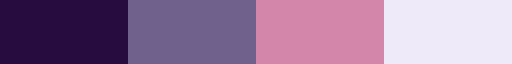

In [16]:
original_cmap = cr.acton
ncolors = 4
resampledcmap = original_cmap.resampled(ncolors)
colors_list = [resampledcmap(i) for i in range(ncolors)]
colors_list = colors_list[1:-1:1]
resampledcmap